In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phbs-kaggle-optiver-feature/cross_section_features.parquet
/kaggle/input/phbs-kaggle-optiver-feature/market_features.parquet
/kaggle/input/phbs-kaggle-optiver-feature/timeseries_features.parquet
/kaggle/input/phbs-kaggle-optiver-feature/submission.csv
/kaggle/input/phbs-kaggle-optiver-feature/ipynb_features.parquet


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
SEED = 42

# 1.(co-)multi-linear feature_impoartances

**multilinear影响**  
输出的特征重要性排序在不同sample，特征顺序，种子上不稳定  
两个相似的样本会互相降低feature_importance  
删去一个特征使得其他特征的重要性排序发生明显改变  


## 1.2读取横截面因子

In [6]:
cross_section_features = pd.read_parquet(os.path.join(dirname, "cross_section_features.parquet")).iloc[:100000]

In [9]:
cross_section_features.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('float32')],
      dtype=object)

In [10]:
cross_section_features.dtypes[cross_section_features.dtypes=='O']

row_id    object
dtype: object

使用前把“row_id”和“target”drop掉

In [7]:
X_train = cross_section_features.query("target.notna()").drop(['row_id'], axis=1)
y_train = X_train.pop("target")

In [18]:
X_train.columns[X_train.isnull().sum()!=0]

Index(['wap_y', 'mid_price_y'], dtype='object')

In [24]:
X_train.query("seconds_in_bucket>300")[['wap_y', 'mid_price_y']].isnull().sum()

wap_y          0
mid_price_y    0
dtype: int64

In [8]:
X_train.drop(['wap_y', 'mid_price_y'],axis=1,inplace=True)

看一下有inf的值

In [9]:
cols_contain_inf = (
    X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ]
)

inf换成nan

In [10]:
X_train[cols_contain_inf] = (
    X_train
    [cols_contain_inf]
    .mask(
        np.isinf(X_train[cols_contain_inf])
    )
)

In [39]:
(X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ])

Index([], dtype='object')

# 3.correlation和feature_importances

## 3.1 相关性

In [40]:
corr_matrix = X_train.corr()

20个看一下热力图, 有一些高度相关的

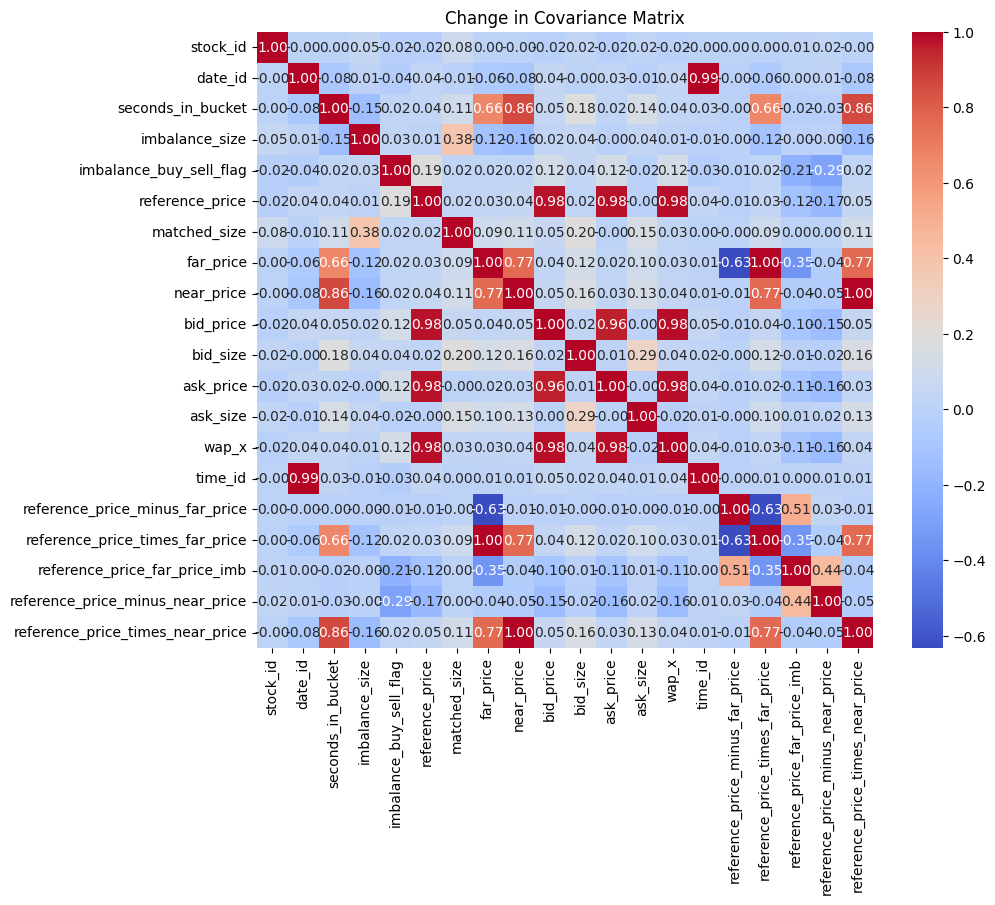

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.iloc[:20,:20], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix')
plt.show()

按顺序排的平均相关性的绝对值

<Axes: >

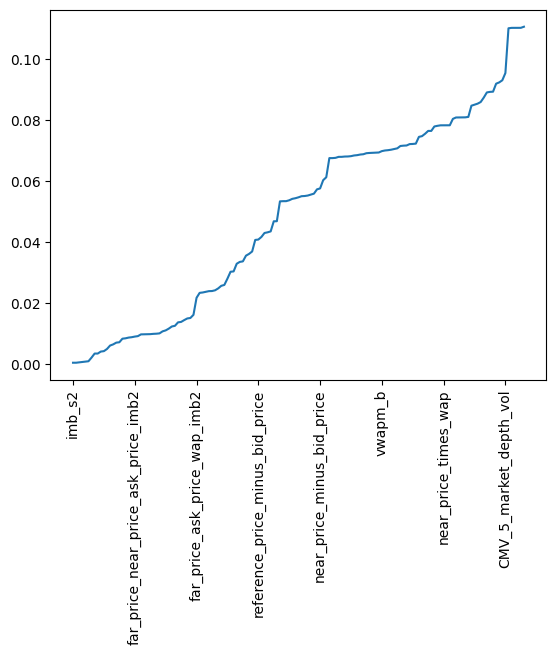

In [64]:
corr_matrix.mean().abs().sort_values().plot(rot=90)

In [65]:
feature_corr_series = corr_matrix.mean()

## 3.2 5折训练的lightgbm的平均重要性，permutation重排2次
split，gain

In [18]:
estimator = lightgbm.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='gain',#split
    force_row_wise=True
)

In [15]:
n_splits = 5
n_repeats = 1

In [75]:
val_predictions = np.zeros(len(X_train))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

[LightGBM] [Info] Total Bins 34510
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 147
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 35090
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 147
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 147
[LightGBM] [Info] Start training from score -0.200272
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 66668, number of used features: 147
[LightGBM] [Info] Start training from score -0.159740
[LightGBM] [Info] Total Bins 35191
[LightGBM] [Info] Number of data points in the train set: 83334, number of used features: 147
[LightGBM] [Info] Start training from score -0.119805
Val Score: 4.95 ± 0.27641


存gain和permuation的importance

In [83]:
gain_feature_importance_series = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [102]:
permutation_feature_importance_series = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)

In [243]:
feature_importance_and_corr = pd.concat(
    [
        permuation_feature_importance_series.to_frame().rename(columns={0:"permuation_feature_importance"}),
        gain_feature_importance_series.to_frame().rename(columns={0:"gain_feature_importance"}),
        feature_corr_series.to_frame().rename(columns={0:"feature_corr_mean"})
    ],
    axis=1
)

## 3.3比较一下重要性和相关性

describe看一下数据分布

In [205]:
feature_importance_and_corr.describe()

,permuation_feature_importance,gain_feature_importance,feature_corr_mean
count,151.000000,151.000000,147.000000
mean,0.002831,686.108118,0.038679
std,0.015790,1634.553109,0.043595
min,-0.001019,0.000000,-0.085080
25%,-0.000007,84.061160,0.009544
50%,0.000087,217.888081,0.043567
75%,0.000395,581.506996,0.071601
max,0.166862,11667.284659,0.110619


画个图（
数据分布方差大，又不好删
1.clip 3被sigma
2.loglog
3.rank
）

In [238]:
feature_importance_and_corr["permuation_feature_importance"] = feature_importance_and_corr["permuation_feature_importance"].sort_values().clip(-1000,0.001)#.plot(marker="o")

In [239]:
def log_xplus(df,plus=1):
    return np.log(df-df.min()+plus)
def loglog(df,times=2,plus=1):
    if times==0:
        return df
    return loglog(log_xplus(df,plus),times-1)

In [240]:
loglog_feature_importance_and_corr = loglog(feature_importance_and_corr,1,1)

<Axes: >

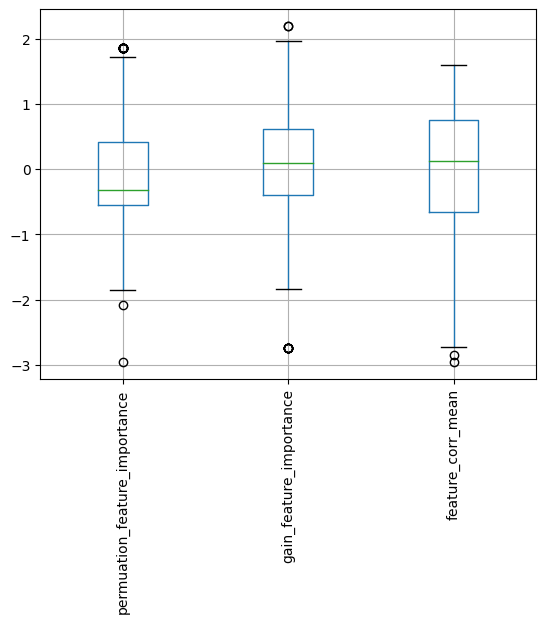

In [241]:
scaler = StandardScaler()
scaler.fit(loglog_feature_importance_and_corr)
pd.DataFrame(
    scaler.fit_transform(loglog_feature_importance_and_corr),
    columns=loglog_feature_importance_and_corr.columns,
    index=loglog_feature_importance_and_corr.index
).boxplot(rot=90)

**和其他特征相关性高的更容易在gain的排序下变得不重要，permutation能避免（相关性0.06）**

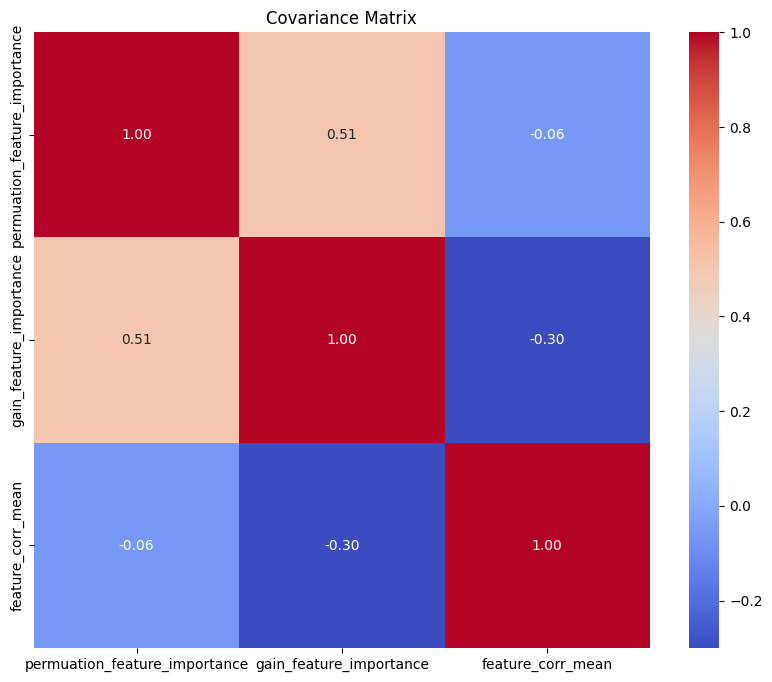

In [246]:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_importance_and_corr.rank().corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix')
plt.show()

# 3.相似的特征和feature_importances

特征加噪声

In [47]:
X_train_std = X_train.std()
X_train_noise = np.array([np.random.normal(0,X_train_std) for _ in tqdm(range(len(X_train)))])

100%|██████████| 100000/100000 [00:03<00:00, 26696.81it/s]


In [48]:
X_train.corrwith(X_train+X_train_noise).min().min()

0.7035801345942334

In [50]:
X_train_double = X_train.merge(X_train+X_train_noise,left_index=True,right_index=True)

run一下重要性

In [51]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

[LightGBM] [Info] Total Bins 71995
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 294
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 72575
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 294
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 72675
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 294
[LightGBM] [Info] Start training from score -0.200272
[LightGBM] [Info] Total Bins 72675
[LightGBM] [Info] Number of data points in the train set: 66668, number of used features: 294
[LightGBM] [Info] Start training from score -0.159740
[LightGBM] [Info] Total Bins 72676
[LightGBM] [Info] Number of data points in the train set: 83334, number of used features: 294
[LightGBM] [Info] Start training from score -0.119805
Val Score: 4.97 ± 0.25216


In [52]:
permutation_feature_importance_series_double = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_double = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [58]:
X_train_double = X_train.copy()

In [59]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

[LightGBM] [Info] Total Bins 34510
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 147
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 35090
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 147
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 147
[LightGBM] [Info] Start training from score -0.200272
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 66668, number of used features: 147
[LightGBM] [Info] Start training from score -0.159740
[LightGBM] [Info] Total Bins 35191
[LightGBM] [Info] Number of data points in the train set: 83334, number of used features: 147
[LightGBM] [Info] Start training from score -0.119805
Val Score: 4.95 ± 0.27641


In [60]:
permutation_feature_importance_series = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [89]:
permutation_feature_importance_df = permutation_feature_importance_series.to_frame().rename(columns={0:"permutation_feature_importance"})
permutation_feature_importance_df["permutation_feature_importance_origin"] = permutation_feature_importance_series_double.iloc[:151].values
permutation_feature_importance_df["permutation_feature_importance_withnoise"] = permutation_feature_importance_series_double.iloc[151:].values

In [103]:
gain_feature_importance_df = gain_feature_importance_series.to_frame().rename(columns={0:"gain_feature_importance"})
gain_feature_importance_df["gain_feature_importance_origin"] = gain_feature_importance_series_double.iloc[:151].values
gain_feature_importance_df["gain_feature_importance_withnoise"] = gain_feature_importance_series_double.iloc[151:].values

画个图

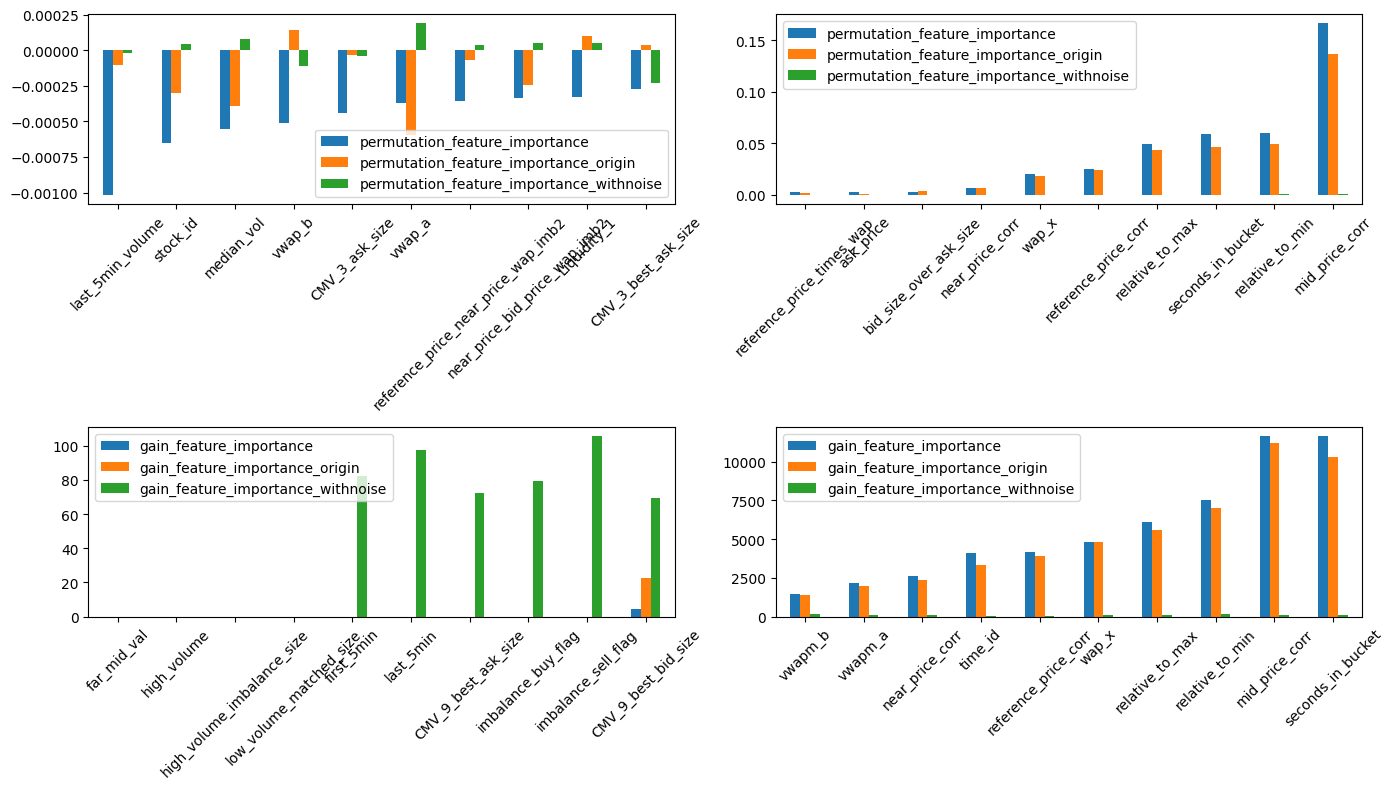

In [106]:
fig,axes = plt.subplots(2,2,figsize=(14,8))
permutation_feature_importance_df.sort_values("permutation_feature_importance").iloc[0:10].plot(kind="bar",rot=45,ax=axes.flatten()[0])
permutation_feature_importance_df.sort_values("permutation_feature_importance").iloc[-10:].plot(kind="bar",rot=45,ax=axes.flatten()[1])
gain_feature_importance_df.sort_values("gain_feature_importance").iloc[0:10].plot(kind="bar",rot=45,ax=axes.flatten()[2])
gain_feature_importance_df.sort_values("gain_feature_importance").iloc[-10:].plot(kind="bar",rot=45,ax=axes.flatten()[3])
plt.tight_layout()

<Axes: >

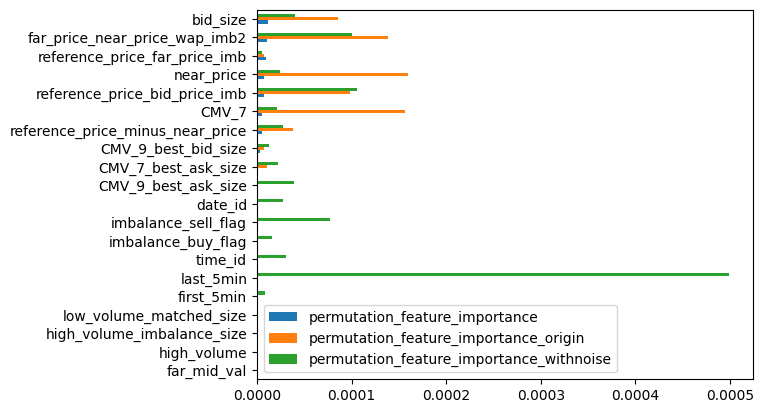

In [109]:
permutation_feature_importance_df.abs().sort_values("permutation_feature_importance").iloc[:20].plot.barh()#(kind="bar",figsize=(14,4))

**重要性高的特征受噪声影响小**  
**重要性为0的特征如果有一些和他相关性高（>0.7）的特征可能会被分配一些重要性**  
**重要性低的特征受共线性影响变化大**

# 4.去部分特征后feature_importances排序变化

In [115]:
X_train_double = X_train.drop("mid_price_corr",axis=1)

In [116]:
val_predictions = np.zeros(len(X_train_double))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_double, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_double.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_double.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_double.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

[LightGBM] [Info] Total Bins 34262
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 146
[LightGBM] [Info] Start training from score -0.519753
[LightGBM] [Info] Total Bins 34835
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 146
[LightGBM] [Info] Start training from score -0.309944
[LightGBM] [Info] Total Bins 34935
[LightGBM] [Info] Number of data points in the train set: 50002, number of used features: 146
[LightGBM] [Info] Start training from score -0.200272
[LightGBM] [Info] Total Bins 34935
[LightGBM] [Info] Number of data points in the train set: 66668, number of used features: 146
[LightGBM] [Info] Start training from score -0.159740
[LightGBM] [Info] Total Bins 34936
[LightGBM] [Info] Number of data points in the train set: 83334, number of used features: 146
[LightGBM] [Info] Start training from score -0.119805
Val Score: 4.97 ± 0.26666


In [117]:
permutation_feature_importance_series_del1 = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_del1 = pd.concat(feature_importance_list,axis=1).mean(axis=1)

In [121]:
gain_feature_importance_series_del1.nlargest(10)

reference_price_corr    14573.942800
seconds_in_bucket       10992.429274
relative_to_min          7428.458329
relative_to_max          6319.028388
wap_x                    4340.483012
time_id                  4228.417712
near_price_corr          2465.811266
vwapm_a                  2103.334847
vwapm_b                  1595.435436
far_price_corr           1474.931438
dtype: float64

In [120]:
permutation_feature_importance_series_del1.nlargest(10)

reference_price_corr               0.223227
relative_to_min                    0.055354
relative_to_max                    0.052564
seconds_in_bucket                  0.049758
wap_x                              0.021271
near_price_corr                    0.007702
ask_price                          0.002270
bid_size_over_ask_size             0.002027
ask_price_times_wap                0.002017
reference_price_times_ask_price    0.001886
dtype: float64

**顺序有一些变化**

# 5.减少multilinear影响的方法

1. permutation, 换seed
2. SHAP值

gain、split、count和萨巴斯法得出的特征重要性值都是不一致的。这意味着模型可能会发生变化，从而更加依赖于某个给定的特征，但分配给该特征的重要性估计值却会降低。 在我们考虑的方法中，只有 SHAP 值和基于排列的方法是一致的。  
“the feature importance values from the gain,split, count, and Saabas methods are all inconsistent. This means that a model can change such that it relies more on a given feature, yet the importance estimate assigned to that feature decreases.  Of the methods weconsider,only SHAP values and permutation based methods arec onsistent.”

![attribution.png](attribution.png)

In [110]:
# result1 = []#cross_section_features[['reference_price',"matched_size"]].copy()
# def section_scalar(df):
#     # 对 'reference_price' 列进行标准化
#     scaler = StandardScaler()
#     scaler.fit(df)
#     print(df.info())
#     scaled_values = scaler.fit_transform(df)
#     result1.extend(scaled_values.tolist())
#     del scaled_values
#     gc.collect()
#     return 

# tqdm.pandas(desc="Processing groups")
# # 对每个分组应用标准化
# scaled_f1 = (
#     cross_section_features
#     [selected_cols]
#     #.query("date_id<10")
#     #.dropna(axis=1)
#     .drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket'],axis=1)
#     .groupby(['date_id'])
#     .progress_apply(section_scalar)
# )

In [31]:
# scaled_cross_section_features = pd.DataFrame(np.array(result1),
#              index=cross_section_features.sort_values("date_id").row_id,
#              columns=cross_section_features[selected_cols].drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket'],axis=1).columns
#             )

In [111]:
# # 计算 VIF
# def calculate_vif(df):
#     vif_data = pd.DataFrame()
#     vif_data["Variable"] = df.columns
#     vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in tqdm(range(df.shape[1]))]
#     return vif_data

# # 假设 df 只有数值型数据
# vif_result = calculate_vif(X_train.replace(np.nan,0))#cross_section_features[selected_cols].drop(["stock_id","row_id","time_id","imbalance_buy_sell_flag",'seconds_in_bucket','date_id'],axis=1).replace(np.nan,0).iloc[:,:])